In [38]:
%pip install numpy
%pip install pandas
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display_functions import clear_output,display


import math
import os



In [40]:
species_values = ['Iris-setosa','Iris-versicolor','Iris-virginica']

In [41]:
read_from_checkpoint = False

if(not read_from_checkpoint):
    all_data = pd.read_csv("iris.csv")
    all_data = all_data.sample( frac=1) # shuffle
    for species_value in species_values:
        all_data['Species_' + species_value] = (all_data['Species'] == species_value).astype(int)



    cutoff = math.floor(len(all_data) * 0.8)

    training_data = all_data.iloc[:cutoff,:].reset_index(drop=True)
    testing_data = all_data.iloc[cutoff:,:].reset_index(drop=True)

    os.makedirs("checkpoint",exist_ok=True)
    training_data.to_csv('checkpoint/trainingdata.csv',index=False)
    testing_data.to_csv('checkpoint/testingdata.csv',index=False)
else:
    training_data = pd.read_csv('checkpoint/trainingdata.csv')
    testing_data = pd.read_csv('checkpoint/testingdata.csv')


training_data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
0,146,6.7,3.0,5.2,2.3,Iris-virginica,0,0,1
1,63,6.0,2.2,4.0,1.0,Iris-versicolor,0,1,0
2,109,6.7,2.5,5.8,1.8,Iris-virginica,0,0,1
3,122,5.6,2.8,4.9,2.0,Iris-virginica,0,0,1
4,81,5.5,2.4,3.8,1.1,Iris-versicolor,0,1,0
...,...,...,...,...,...,...,...,...,...
115,113,6.8,3.0,5.5,2.1,Iris-virginica,0,0,1
116,72,6.1,2.8,4.0,1.3,Iris-versicolor,0,1,0
117,22,5.1,3.7,1.5,0.4,Iris-setosa,1,0,0
118,116,6.4,3.2,5.3,2.3,Iris-virginica,0,0,1


In [42]:
def activationFunction(logit): # sigmoid
  return 1/(1+ math.exp(-logit))

In [43]:
layer0_size = 4
layer1_size = 5
layer2_size = 3


layer0_outputs = np.zeros(layer0_size)
layer1_outputs = np.zeros(layer1_size)
layer2_outputs = np.zeros(layer2_size)


layer1_logit = np.zeros(layer1_size)
layer2_logit = np.zeros(layer2_size)


layer1_weights = np.random.uniform(-1,1,size=(layer0_size,layer1_size))
layer2_weights = np.random.uniform(-1,1,size=(layer1_size,layer2_size))

layer1_biases = np.random.uniform(-1,1,size=layer1_size)
layer2_biases = np.random.uniform(-1,1,size=layer2_size)

layer2_delta = np.zeros(layer2_size)
layer1_delta = np.zeros(layer1_size)



error_threshold = 0.2
learning_rate = 0.2

bad_facts_per_epoch = []

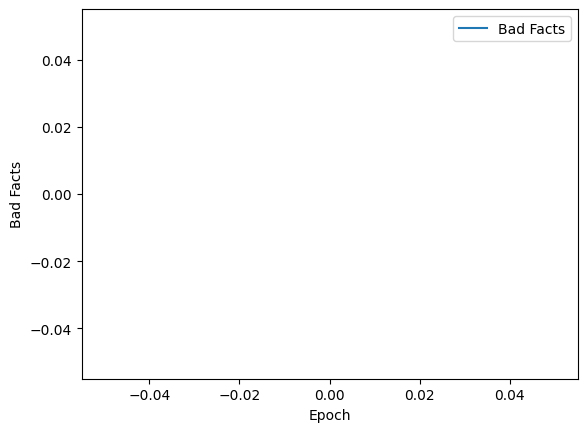

In [44]:
bad_facts_fig, bad_facts_ax = plt.subplots()
bad_facts_ln, = bad_facts_ax.plot([], [], label='Bad Facts')

bad_facts_ax.set_xlabel('Epoch')
bad_facts_ax.set_ylabel('Bad Facts')
bad_facts_ax.legend(loc='upper right')

def update_graphs():
    bad_facts_ln.set_data(range(len(bad_facts_per_epoch)),bad_facts_per_epoch)
    bad_facts_fig.gca().relim()
    bad_facts_fig.gca().autoscale_view()
    
    clear_output(wait=True)
    display(bad_facts_fig)

In [45]:
def forward_prop_layer(layer_inputs,layer_weights,layer_logit,layer_ouputs):
    np.matmul(layer_inputs,layer_weights,out=layer_logit)
    
    for i in range(len(layer_ouputs)):
        layer_ouputs[i] = activationFunction(layer_logit[i])
    
    

In [46]:
def forward_prop(inputs):
    layer0_outputs[:] = np.array(inputs)
    forward_prop_layer(layer0_outputs,layer1_weights,layer1_logit,layer1_outputs)
    forward_prop_layer(layer1_outputs,layer2_weights,layer2_logit,layer2_outputs)
    

In [47]:
def back_prop_output_layer(layer_outputs,targets,layer_weights,layer_delta,prev_layer_ouputs):
    layer_delta[:] = layer_outputs*(1-layer_outputs) * (targets-layer_outputs)

    delta_W = np.outer(prev_layer_ouputs,layer_delta.T) * learning_rate

    layer_weights += delta_W

    

In [48]:
def back_prop_hidden_layer(output_weights,layer_outputs,layer_weights,prev_layer_outputs,next_layer_deltas,layer_delta):


    sums = []

    for p in range(output_weights.shape[0]):
        sum = 0
        for q in range(output_weights.shape[1]):
            sum += next_layer_deltas[q] * output_weights[p,q]
        sums.append(sum)


    layer_delta[:] = layer_outputs*(1-layer_outputs) * (sums)

    delta_W = np.outer(prev_layer_outputs,layer_delta.T) * learning_rate

    layer_weights += delta_W

In [49]:
def back_prop(target):
    back_prop_output_layer(layer2_outputs,target,layer2_weights,layer2_delta,layer1_outputs)
    back_prop_hidden_layer(layer2_weights,layer1_outputs,layer1_weights,layer0_outputs,layer2_delta,layer1_delta)

In [50]:
def train():
    for epoch in range(10000):
        bad_facts = 0
        for i in range(len(training_data.index)):
    
            
    
            forward_prop(training_data.loc[i,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].values.astype(float))
    
            target = training_data.loc[i,['Species_Iris-setosa','Species_Iris-versicolor','Species_Iris-virginica']].values.astype(float)
    
            error = target - layer2_outputs
    
            output_outside_threshold = np.abs(error) > error_threshold
    
            if np.any(output_outside_threshold):
                bad_facts += 1
                
                back_prop(target)
            
             
        
        bad_facts_per_epoch.append(bad_facts)
        update_graphs()
        if bad_facts == 0:
            return


In [51]:
def test():
    success = []
    
    for i in range(len(testing_data.index)):
    
            
    
            forward_prop(testing_data.loc[i,['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].values.astype(float))
            
            target = testing_data.loc[i,['Species_Iris-setosa','Species_Iris-versicolor','Species_Iris-virginica']].values.astype(float)
    
            error = target - layer2_outputs
    
            output_outside_threshold = np.abs(error) > error_threshold
            
            success.append(not output_outside_threshold.any())
        
    return success

In [52]:
train()
test()

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True]